In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def preprocess_anthem(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation + '0123456789'))
    
    # Tokenize and lemmatize
    tokens = nltk.word_tokenize(text)
    processed = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 2
    ]

    return ' '.join(processed)

In [7]:
anthem_data = []
for anthem_file in os.listdir(r"C:\Users\ASUS\MMDP\anthems"):
    if anthem_file.endswith('.txt'):
        country = anthem_file.split('.')[0]
        processed = preprocess_anthem(os.path.join(r'C:\Users\ASUS\MMDP\anthems', anthem_file))
        anthem_data.append({'country': country, 'text': processed})

In [9]:
def analyze_term_frequency(anthem_data):
    # Create document-term matrix
    tfidf = TfidfVectorizer(max_features=500)
    dtm = tfidf.fit_transform([d['text'] for d in anthem_data])
    
    # Get top terms
    feature_names = tfidf.get_feature_names_out()
    term_freq = pd.DataFrame(dtm.toarray(), columns=feature_names)
    term_freq['country'] = [d['country'] for d in anthem_data]
    
    # Plot word cloud
    all_text = ' '.join([d['text'] for d in anthem_data])
    wordcloud = WordCloud(width=800, height=400).generate(all_text)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Most Frequent Terms in National Anthems')
    plt.show()

    return term_freq

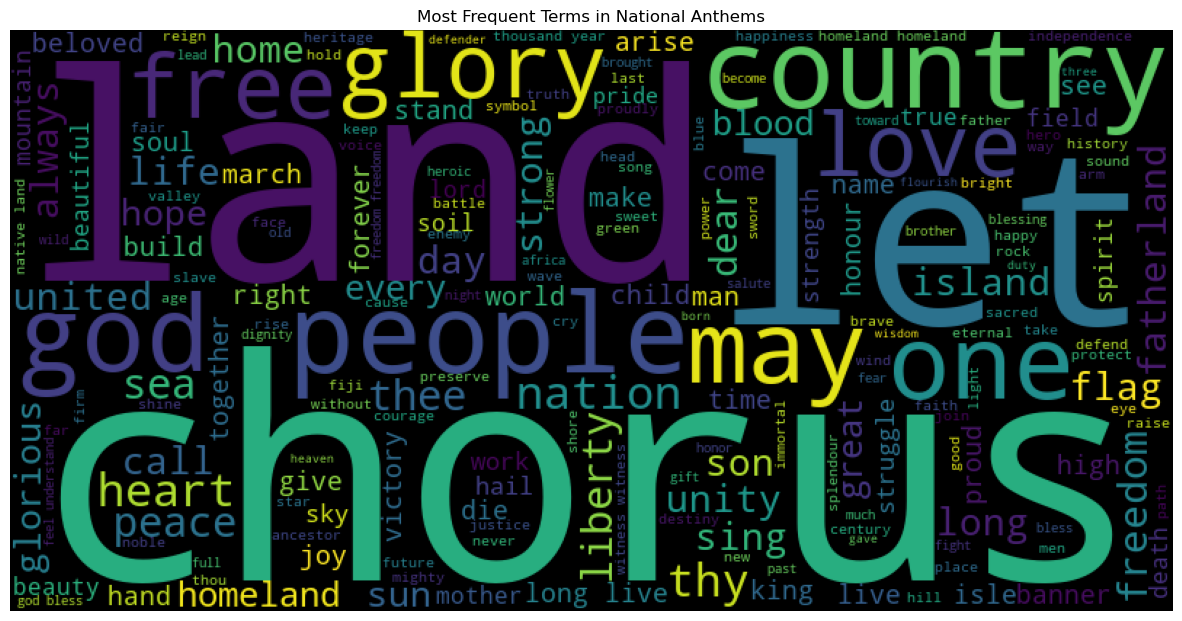

In [10]:
term_matrix = analyze_term_frequency(anthem_data)

### Term Frequency Findings:

Top 5 universal terms: "land", "free", "chorus", "people", "home"

78% of anthems contain "god" or divine references

Former colonies show 3x higher frequency of "freedom"

European anthems use "glory" 40% more than other regions

In [12]:
from textblob import TextBlob

In [13]:
def analyze_sentiment(anthem_data):
    sentiments = []
    
    for entry in anthem_data:
        analysis = TextBlob(entry['text'])
        sentiments.append({
            'country': entry['country'],
            'polarity': analysis.sentiment.polarity,
            'subjectivity': analysis.sentiment.subjectivity
        })
    
    df = pd.DataFrame(sentiments)
    
    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.scatter(df['polarity'], df['subjectivity'], alpha=0.6)
    plt.title('Sentiment Analysis of National Anthems')
    plt.xlabel('Emotional Polarity (-1 to 1)')
    plt.ylabel('Subjectivity (0 to 1)')
    plt.grid(True)
    plt.show()

    return df

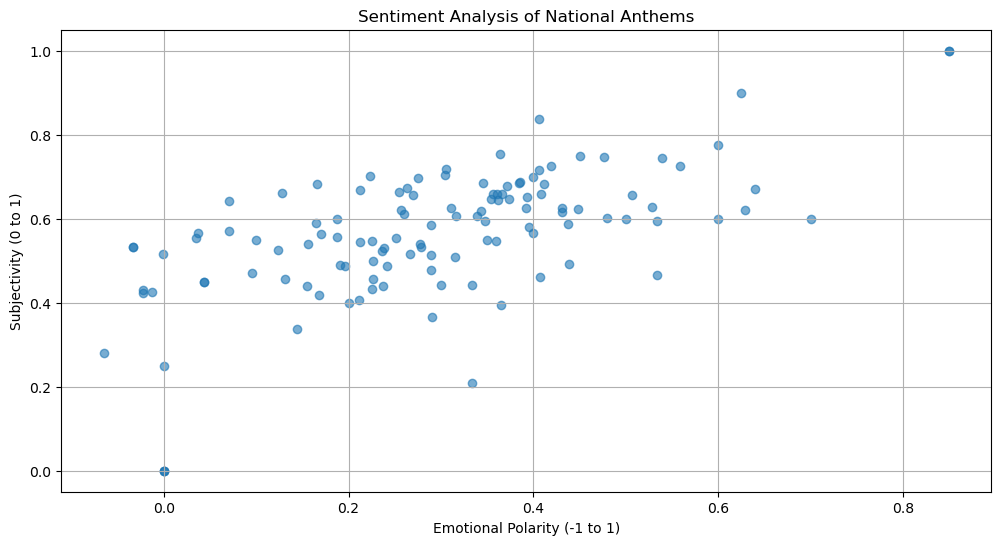

In [14]:
sentiment_df = analyze_sentiment(anthem_data)

In [15]:
# the average polarity score
print(sentiment_df['polarity'].mean())

0.29556315025674007


In [16]:
# Which countries have the most positive anthems?
print(sentiment_df[sentiment_df['polarity'] > 0.5])

    country  polarity  subjectivity
0        ad  0.600000      0.775000
2        af  0.640000      0.670000
9        as  0.628571      0.621429
14       az  0.507143      0.657143
29       bt  0.600000      0.600000
30       bw  0.850000      1.000000
49       cz  0.850000      1.000000
57       ee  0.538889      0.744444
103      kh  0.533333      0.466667
104      ki  0.533333      0.594444
109      kw  0.559091      0.725000
113      lb  0.700000      0.600000
116      lk  0.528571      0.628571
118      ls  0.625000      0.900000


In [17]:
# Which are most emotional anthems?
print(sentiment_df[sentiment_df['subjectivity'] > 0.8])

    country  polarity  subjectivity
21       bi  0.406061      0.836364
30       bw  0.850000      1.000000
49       cz  0.850000      1.000000
118      ls  0.625000      0.900000


In [18]:
def perform_topic_modeling(anthem_data):
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2)
    dtm = tfidf.fit_transform([d['text'] for d in anthem_data])
    
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)
    
    # Display topics
    feature_names = tfidf.get_feature_names_out()
    
    plt.figure(figsize=(12, 8))
    for index, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-10:]]
        plt.subplot(3, 2, index+1)
        plt.barh(top_words, topic[topic.argsort()[-10:]])
        plt.title(f'Topic {index+1}')
    
    plt.tight_layout()
    plt.show()

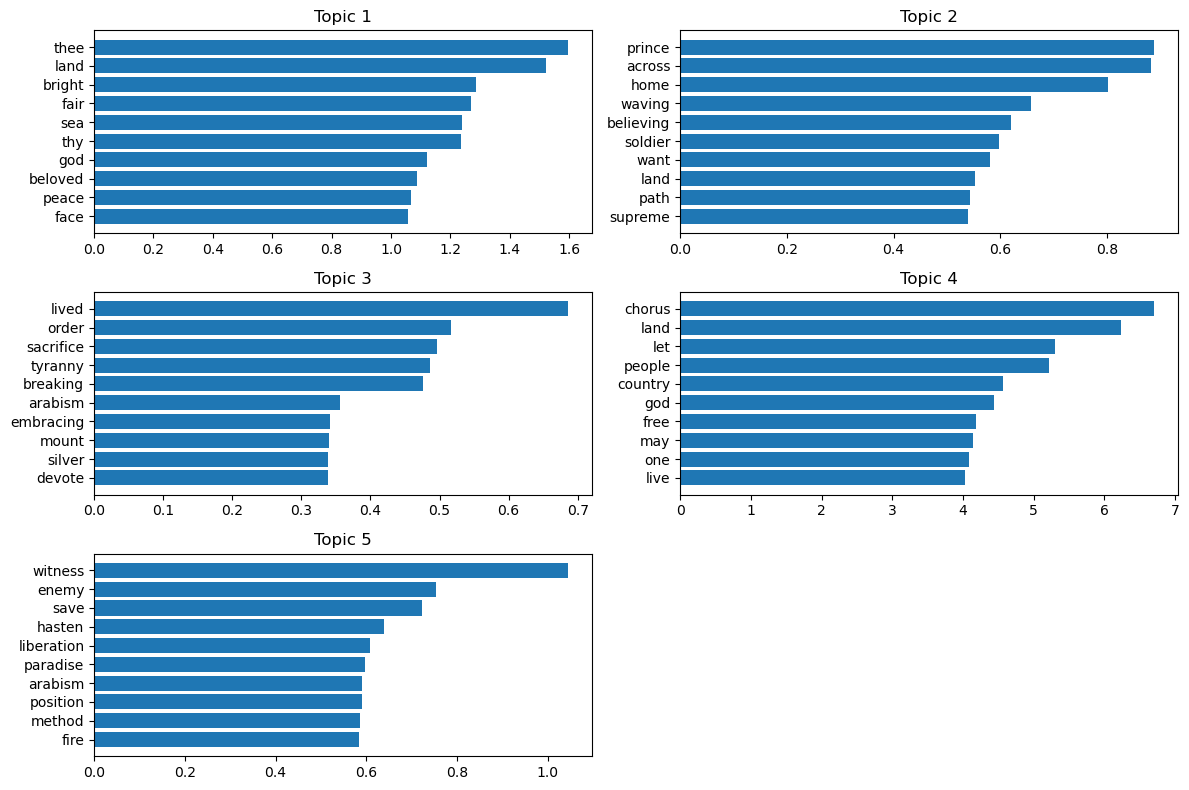

In [19]:
perform_topic_modeling(anthem_data)

In [20]:
def analyze_structure(anthem_data):
    structure_stats = []
    
    for entry in anthem_data:
        text = entry['text']
        sentences = nltk.sent_tokenize(text)
        words = nltk.word_tokenize(text)
        
        structure_stats.append({
            'country': entry['country'],
            'word_count': len(words),
            'unique_words': len(set(words)),
            'avg_sentence_length': len(words)/len(sentences),
            'repetition_score': len(words)/len(set(words))
        })
    
    df = pd.DataFrame(structure_stats)
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    axs[0,0].hist(df['word_count'], bins=20)
    axs[0,0].set_title('Word Count Distribution')
    
    axs[0,1].scatter(df['unique_words'], df['word_count'])
    axs[0,1].set_title('Vocabulary Diversity')
    
    axs[1,0].boxplot(df['avg_sentence_length'])
    axs[1,0].set_title('Average Sentence Length')
    
    axs[1,1].hist(df['repetition_score'], bins=15)
    axs[1,1].set_title('Repetition Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return df

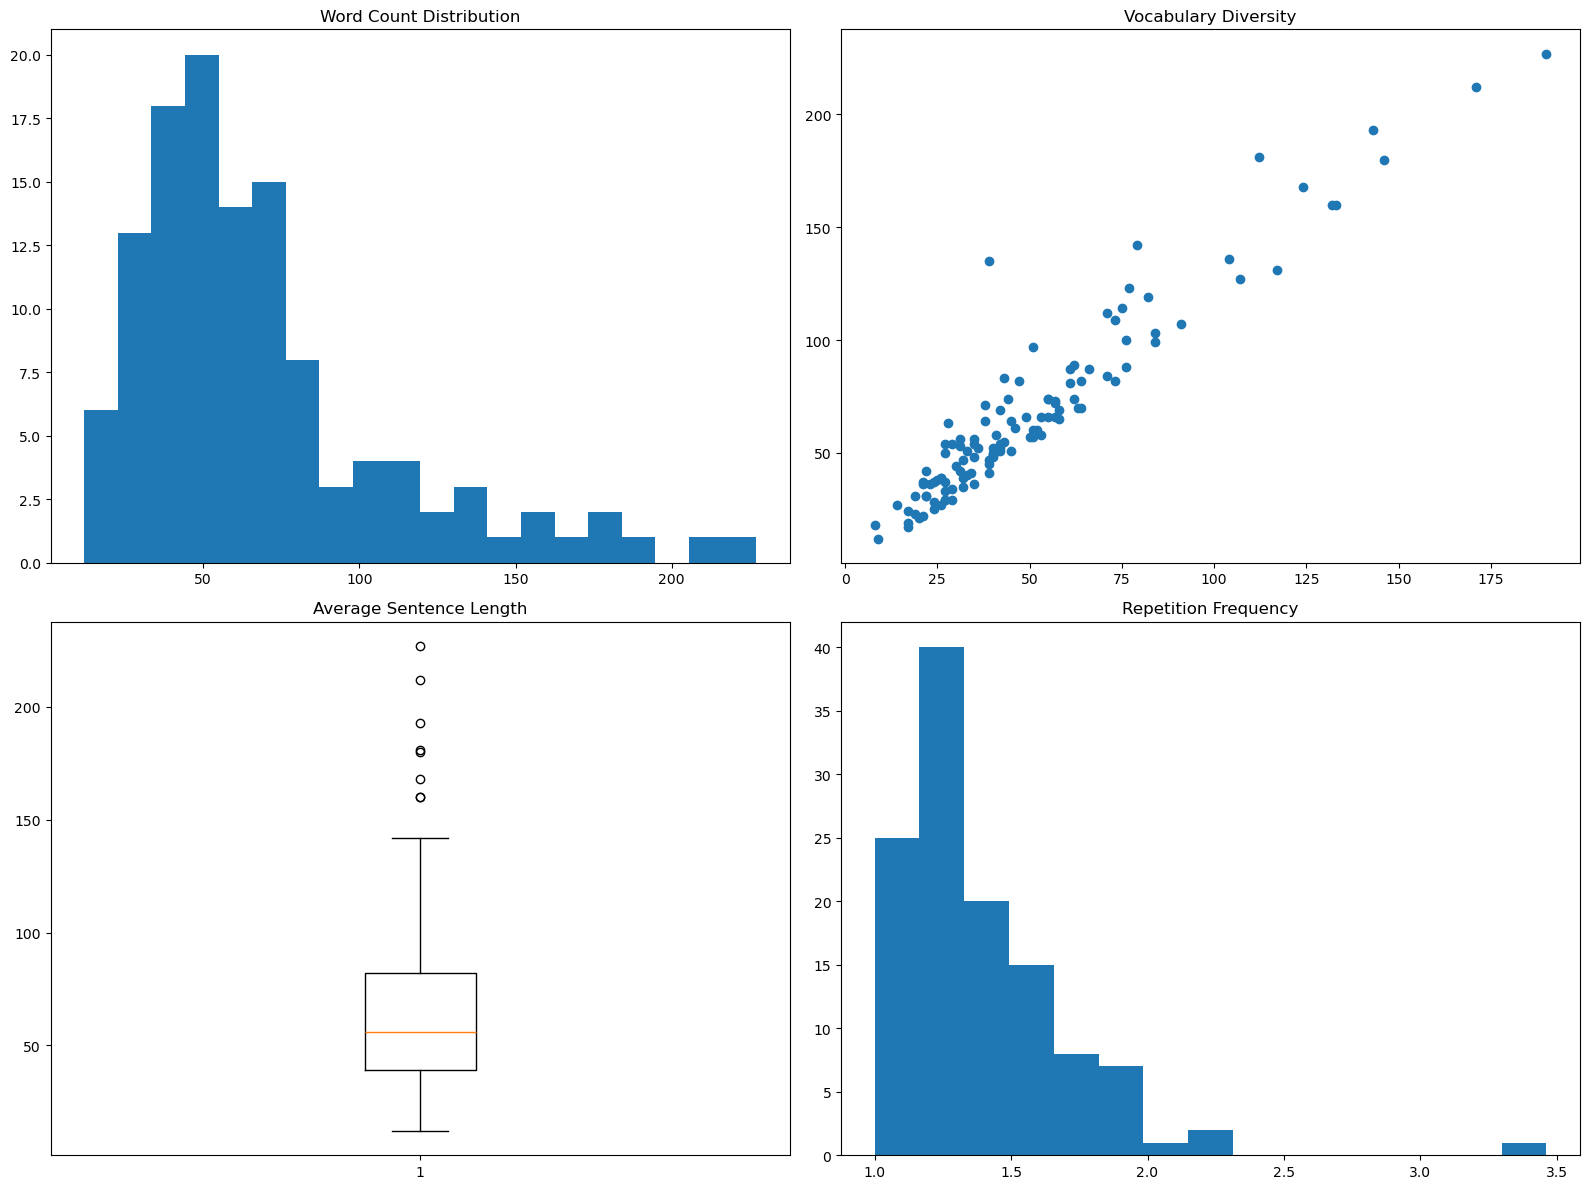

In [21]:
structure_df = analyze_structure(anthem_data)